In [1]:
import numpy as np
import math
import time
import pandas as pd
from tqdm import tqdm
import sklearn
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline

import xgboost as xgb

import data
import features
from model_xgboost import ModelXGBoost
from model_tree_regressor import ModelTreeRegressor

In [2]:
temp, dico = data.load_input_data('data/train_input.csv')
output = data.load_output_data('data/challenge_output.csv', temp, dico)
all_features = features.load_all_features(dico, temp, remove_useless=True)

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:15<00:00, 15.12it/s]


All the features have been loaded in 15.88 sec
19 useless features have been removed. There are now 31 features for each setting.


In [3]:
def scores(model):
    # Test Score
    Y_pred = model.predict_model(model.model, model.X_test)
    mse = sklearn.metrics.mean_squared_error(model.Y_test[:, model.col_var], Y_pred)
    print("MSE on test set:", mse)

    # Train score
    Y_pred_train = model.predict_model(model.model, model.X_train)
    mse_train = sklearn.metrics.mean_squared_error(model.Y_train[:, model.col_var], Y_pred_train)
    print("MSE on train set:", mse_train)
    
    return Y_pred

def plot(model, n1, n2, plot_Y):
    plt.plot(plot_Y[n1:n2], label='prediction')
    plt.plot(model.Y_test[n1:n2, model.col_var], label='ground truth')
    plt.legend()
    plt.show()

### Choose features

In [4]:
t =  '_non_int'

name_features = features.choose_name_features(all_features, t)
for name in ['surface_2_m2_OUTW', 'surface_3_m2_OUTW', 'surface_4_m2_OUTW',
             'window_percent_2_outwall', 'window_percent_3_outwall', 'window_percent_4_outwall',
             'heating_value_t_1', 'AC_value_t_1', 'outside_temp_t_1',
             #'week', 'week_day'
            ]:
    name_features.remove(name)

name_features

['AC_on_non_int',
 'AC_value_non_int',
 'heating_on_non_int',
 'heating_value_non_int',
 'hour',
 'nb_occupants',
 'orientation',
 'outside_temp',
 'surface_1_m2_OUTW',
 'useful_surface_m2',
 'week',
 'week_day',
 'window_percent_1_outwall',
 'heating_value_evol_non_int',
 'AC_value_evol_non_int',
 'outside_temp_evol']

### Modèle XGBoost

In [5]:
def test_xgboost(name_features, all_features, output, var,
                 n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.5):
    
    print("-- Variable: '{}', n_estimators={}, max_depth={}".format(var, n_estimators, max_depth))
    
    model = ModelXGBoost(all_features, output)
    model.load_train_test_set(features_names=name_features, pct_train=.8, do_print=False)

    start_time = time.time()
    model.fit_model(var, n_estimators, max_depth, min_child_weight, subsample)
    print("Execution time: {} min".format(round((time.time() - start_time)/60, 2)))

    Y_pred = scores(model)
    
    return model

def predict_val(name_features, all_features, output, var, X_val,
                n_estimators=100, max_depth=3, min_child_weight=1, subsample=0.5):
    model = ModelXGBoost(all_features, output)
    model.load_train_test_set(features_names=name_features, pct_train=1., do_print=False)
    
    start_time = time.time()
    model.fit_model(var, n_estimators, max_depth, min_child_weight, subsample)
    print("Execution time: {} min".format(round((time.time() - start_time)/60, 2)))
    
    Y_pred = model.predict_model(model.model, X_val)
    
    return Y_pred

In [6]:
X_val = features.load_data_features('./data/test_input.csv', name_features, remove_useless=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 18.92it/s]


All the features have been loaded in 1.91 sec
19 useless features have been removed. There are now 31 features for each setting.


In [7]:
output['fields']

{'Q_total_AC_kW': 2,
 'Q_total_gains_kW': 3,
 'Q_total_heating_kW': 1,
 'Q_total_kW': 4,
 'office_temperature_degreC': 0}

### Train model: one test

-- Variable: 'Q_total_heating_kW', n_estimators=100, max_depth=3
Execution time: 120.99712038040161
MSE on test set: 987.090203584
MSE on train set: 620.009126947


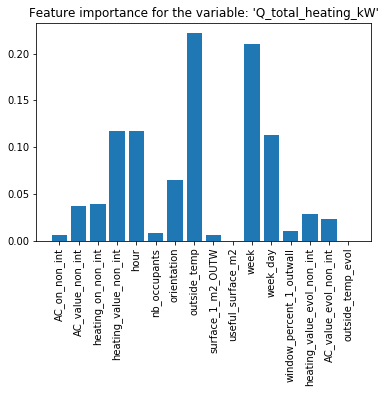

NameError: name 'Y_pred' is not defined

In [11]:
var = 'Q_total_heating_kW'
n_estimators = 100
max_depth = 3
N = 1

for i in range(N):
    model = test_xgboost(name_features, all_features, output, var,
                         n_estimators, max_depth)

Y_pred = model.predict_model(model.model, model.X_test)
# Affichages
model.model_importance()
num_sem = 5
n1, n2 = num_sem*24*7, num_sem*24*7 + 2*24
plot(model, n1, n2, Y_pred)

Y_pred = predict_val(name_features, all_features, output, var, X_val,
                     n_estimators, max_depth)

name_svg = './data/Y_pred/Y_val{}.pkl'.format(t + '_' + n_estimators + max_depth)
pkl.dump(Y_pred, open(name_svg, 'wb'))
print("Prediction saved at " + name_svg)

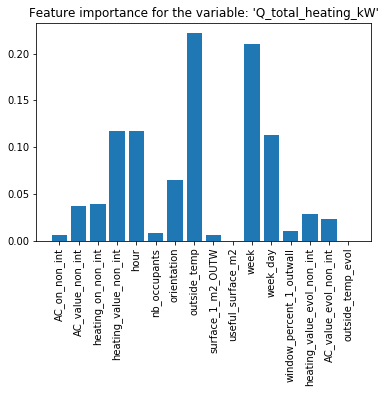

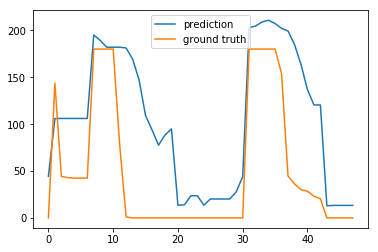

Execution time: 2.97 min


TypeError: must be str, not int

In [12]:
Y_pred = model.predict_model(model.model, model.X_test)
# Affichages
model.model_importance()
num_sem = 5
n1, n2 = num_sem*24*7, num_sem*24*7 + 2*24
plot(model, n1, n2, Y_pred)

Y_pred = predict_val(name_features, all_features, output, var, X_val,
                     n_estimators, max_depth)

name_svg = './data/Y_pred/Y_val{}.pkl'.format(t + '_' + str(n_estimators) + str(max_depth))
pkl.dump(Y_pred, open(name_svg, 'wb'))
print("Prediction saved at " + name_svg)

In [10]:
#Y_pred = pkl.load(open('test_x_val.pkl', 'rb'))

### Boucle sur les variables et différents paramètres

In [ ]:
N = 2

for n_estimators in [100, 1000, 3000, 5000]:
    for max_depth in [3, 5, 10]:
        for var in output['fields']:
            for i in range(N):
                model = test_xgboost(name_features, all_features, output, var,
                                     n_estimators, max_depth)
            
            Y_pred_test = model.predict_model(model.model, model.X_test)
            # Affichages
            model.model_importance()
            num_sem = 5
            n1, n2 = num_sem*24*7, num_sem*24*7 + 7*24
            plot(model, n1, n2, Y_pred_test)
            
            Y_pred_val = predict_val(name_features, all_features, output, var, X_val,
                                 n_estimators, max_depth)

            name_svg = './data/Y_pred/Y_val{}.pkl'.format(t + '_' + str(n_estimators) + str(max_depth))
            pkl.dump(Y_pred_val, open(name_svg, 'wb'))
            print("Prediction saved at " + name_svg)

-- Variable: 'office_temperature_degreC', n_estimators=100, max_depth=3


### Model Tree Regressor

In [13]:
def test_tree(name_features, all_features, output, var):
    model_tree = ModelTreeRegressor(all_features, output)
    model_tree.load_train_test_set(features_names=name_features, pct_train=.8, do_print=False)

    start_time = time.time()
    model_tree.fit_model(var)
    print("Execution time:", time.time() - start_time)
    
    Y_pred_tree = scores(model_tree)
    
    num_sem = 15
    n1, n2 = num_sem*24*7, num_sem*24*7 + 2*24
    plot(model_tree, n1, n2, Y_pred_tree)


3 buildings with 20 settings each in the test set, 9 in the train set
Execution time: 4.6321702003479
MSE on test set: 1165.32274921
MSE on train set: 11.3851626057


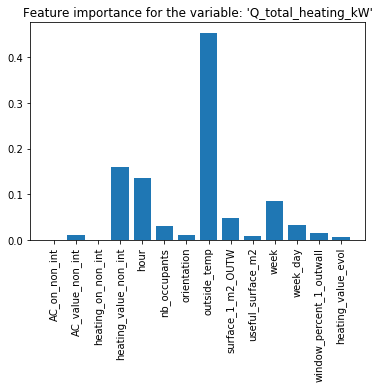

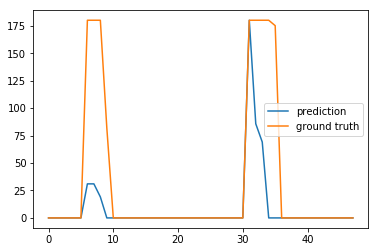

In [52]:
test_tree(name_features, all_features, output, var)

### Plein de tests

| modele |  var       | features type | variables       |MSE test|MSE train| Importance variables |
|--------|------------|---------------|-----------------|--------|---------|----------------------|
| XGBoost| heating_kW | classic       | week, week_day  | 844, 817 |  751, 638 | hour, week, week_day, outside_temp |
| XGBoost| heating_kW | classic       | sans week, week_day  |   982, 864|876, 740   | outside_temp, hour |
| XGBoost| heating_kW | **non_int**   | avec week, week_day  |   **703, 701**  |   608 , 586  | outside_temp, hour, week, week_day, **heating_value** |
| XGBoost| heating_kW | **non_int**   | SANS week, week_day  |  2058, 721|  741, 765| outside_temp, hour, heating_value, AC_value |
| XGBoost| heating_kW | without_lever | AVEC week, week_day  |   854  | 646  |  |
| XGBoost| heating_kW | without_lever & non_int | SANS week, week_day  |   1340  | 613  |  |
| XGBoost| heating_kW | without_lever & non_int | AVEC week, week_day  |   630  | 600  |  |
| XGBoost| heating_kW | without_lever | SANS week, week_day  |   845  | 795  |  |
| Tree   | heating_kW | non_int   | avec week, week_day  | 823| **13** | outside_temp, hour, week, **heating_value** |
| Tree   | heating_kW | classique   | avec week, week_day  | 650, 1001| **10** | |
| Tree   | heating_kW | non_int  | SANS week, week_day  |   823  | 13  |  |
| Tree   | heating_kW | without_lever | AVEC week, week_day  |   680  | 8  |  |
| **Tree**   | heating_kW | **without_lever** | SANS week, week_day  |   **403**  | 149  |  |
| Tree| heating_kW | without_lever & non_int | AVEC week, week_day  |   **472**  | 14  |  |
| Tree| heating_kW | without_lever & non_int | SANS week, week_day  |   564  | 118  |  |

In [19]:
all_features = features.load_all_features(dico, temp, remove_useless=True)

t = '_non_int'

all_features = add_feature_evol_heating(all_features, t)

name_features = features.choose_name_features(all_features, t)
for name in ['surface_2_m2_OUTW', 'surface_3_m2_OUTW', 'surface_4_m2_OUTW',
             'window_percent_2_outwall', 'window_percent_3_outwall', 'window_percent_4_outwall',
             'heating_value_t_1',
             #'week', 'week_day'
            ]:
    name_features.remove(name)

print(name_features)
model = ModelXGBoost(all_features, output)
model.load_train_test_set(features_names=name_features, pct_train=.8, do_print=False)

col_var = 1

# increase n_estimators = 1000
model_xgb = xgb.XGBRegressor(silent=False, n_estimators=1000)
model_xgb.fit(model.X_train , model.Y_train[:, col_var])

# Test Score
Y_pred = model_xgb.predict(model.X_test)
mse = sklearn.metrics.mean_squared_error(model.Y_test[:, col_var], Y_pred)
print("MSE on test set:", mse)

# Train score
Y_pred_train = model_xgb.predict(model.X_train)
mse_train = sklearn.metrics.mean_squared_error(model.Y_train[:, col_var], Y_pred_train)
print("MSE on train set:", mse_train)

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [00:13<00:00, 17.95it/s]


All the features have been loaded in 13.37 sec
16 useless features have been removed. There are now 31 features for each setting.
['AC_on_non_int', 'AC_value_non_int', 'heating_on_non_int', 'heating_value_non_int', 'hour', 'nb_occupants', 'orientation', 'outside_temp', 'surface_1_m2_OUTW', 'useful_surface_m2', 'week', 'week_day', 'window_percent_1_outwall', 'heating_value_evol']
MSE on test set: 428.061385209
MSE on train set: 411.749406505
MSE on test set: 492.31411394
MSE on train set: 590.619836496
MSE on test set: 504.085574714
MSE on train set: 599.129069104


In [10]:
model = ModelXGBoost(all_features, output)
model.load_train_test_set(features_names=name_features, pct_train=.8, do_print=False)
col_var = 1

model_xgb = xgb.XGBRegressor(silent=False, min_child_weight=0.5)
model_xgb.fit(model.X_train , model.Y_train[:, col_var])

# Test Score
Y_pred = model_xgb.predict(model.X_test)
mse = sklearn.metrics.mean_squared_error(model.Y_test[:, col_var], Y_pred)
print("MSE on test set:", mse)

# Train score
Y_pred_train = model_xgb.predict(model.X_train)
mse_train = sklearn.metrics.mean_squared_error(model.Y_train[:, col_var], Y_pred_train)
print("MSE on train set:", mse_train)

MSE on test set: 554.965271657
MSE on train set: 568.9927196


In [11]:
model = ModelXGBoost(all_features, output)
model.load_train_test_set(features_names=name_features, pct_train=.8, do_print=False)


model_xgb = xgb.XGBRegressor(silent=False, n_estimators=1000, max_depth=5)
model_xgb.fit(model.X_train , model.Y_train[:, col_var])

# Test Score
Y_pred = model_xgb.predict(model.X_test)
mse = sklearn.metrics.mean_squared_error(model.Y_test[:, col_var], Y_pred)
print("MSE on test set:", mse)

# Train score
Y_pred_train = model_xgb.predict(model.X_train)
mse_train = sklearn.metrics.mean_squared_error(model.Y_train[:, col_var], Y_pred_train)
print("MSE on train set:", mse_train)

KeyboardInterrupt: 

In [ ]:
model = ModelXGBoost(all_features, output)
model.load_train_test_set(features_names=name_features, pct_train=.8, do_print=False)


model_xgb = xgb.XGBRegressor(silent=False)
model_xgb.fit(model.X_train , model.Y_train[:, col_var])

# Test Score
Y_pred = model_xgb.predict(model.X_test)
mse = sklearn.metrics.mean_squared_error(model.Y_test[:, col_var], Y_pred)
print("MSE on test set:", mse)

# Train score
Y_pred_train = model_xgb.predict(model.X_train)
mse_train = sklearn.metrics.mean_squared_error(model.Y_train[:, col_var], Y_pred_train)
print("MSE on train set:", mse_train)

### Courbes

In [42]:
num_col = output['fields'][var]
output['fields']

{'Q_total_AC_kW': 2,
 'Q_total_gains_kW': 3,
 'Q_total_heating_kW': 1,
 'Q_total_kW': 4,
 'office_temperature_degreC': 0}

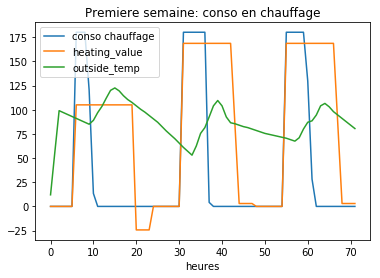

In [36]:
b = 'building_10_0'
n1, n2= 0, 3*24

plt.plot(output[b][n1:n2, num_col], label='conso chauffage')
plt.title("Premiere semaine: conso en chauffage")
plt.xlabel("heures")
to_plot = [(x - 17)*30 for x in all_features[b]['heating_value_non_int'][n1:n2]]
plt.plot(to_plot, label='heating_value')
plt.plot([x*10 for x in all_features[b]['outside_temp'][n1:n2]], label='outside_temp')
plt.legend()
plt.show()

In [31]:
all_features[b].keys()

Index(['AC_on', 'AC_on_non_int', 'AC_on_without_lever',
       'AC_on_without_lever_non_int', 'AC_value', 'AC_value_non_int',
       'AC_value_without_lever', 'AC_value_without_lever_non_int',
       'heating_on', 'heating_on_non_int', 'heating_on_without_lever',
       'heating_on_without_lever_non_int', 'heating_value',
       'heating_value_non_int', 'heating_value_without_lever',
       'heating_value_without_lever_non_int', 'hour', 'nb_occupants',
       'orientation', 'outside_temp', 'surface_1_m2_OUTW', 'surface_2_m2_OUTW',
       'surface_3_m2_OUTW', 'surface_4_m2_OUTW', 'useful_surface_m2', 'week',
       'week_day', 'window_percent_1_outwall', 'window_percent_2_outwall',
       'window_percent_3_outwall', 'window_percent_4_outwall'],
      dtype='object')